In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
# 1. DEFINIÇÃO DOS CAMINHOS
# ----------------------------------------------------------------------
caminho_X_train = "dados_processados/XTrain.csv"
caminho_X_test  = "dados_processados/XTest.csv"
caminho_y_train = "dados_processados/YTrain.csv"
caminho_y_test  = "dados_processados/YTest.csv"

try:

    # 2. LEITURA DOS ARQUIVOS
    # ------------------------------------------------------------------

    df_X_train = pd.read_csv(caminho_X_train)
    df_X_test  = pd.read_csv(caminho_X_test)
    df_y_train = pd.read_csv(caminho_y_train)
    df_y_test  = pd.read_csv(caminho_y_test)

    # 3. EXTRAÇÃODADOS 
    # ------------------------------------------------------------------

  
    #modificar para coloar as features, colocar tudo gera erro
    #FEATURES_SELECIONADAS = df_X_train.columns.tolist()
    FEATURES_SELECIONADAS = ['MEAN_RR', 'RMSSD', 'pNN50', 'LF', 'HF', 'SD1', 'SD2']


    print(f"Features identificadas ({len(FEATURES_SELECIONADAS)}): {FEATURES_SELECIONADAS}")

   
    #X_train = df_X_train.values
    #df_X_train_filtrado = df_X_train[FEATURES_SELECIONADAS] 
    #X_test_filtrado = df_X_test[FEATURES_SELECIONADAS].values

    #X_train = df_X_train_filtrado.values
    #X_test  = df_X_test.values
    #X_test  = df_X_test_filtrado.values

    df_X_train_filtrado = df_X_train[FEATURES_SELECIONADAS] 
    df_X_test_filtrado = df_X_test[FEATURES_SELECIONADAS] # <-- O erro está aqui!

    print(f"Features utilizadas ({len(FEATURES_SELECIONADAS)}): {FEATURES_SELECIONADAS}")
    
    # 4. CONVERSÃO FINAL PARA MATRIZES NUMPY (Para uso no OLS manual)
    X_train = df_X_train_filtrado.values
    X_test  = df_X_test_filtrado.values
    
    y_train = df_y_train.iloc[:, 0].values
    y_test  = df_y_test.iloc[:, 0].values

    #betas_finais = treinar_ols(X_train_filtrado, y_train)


    # Verificação de Shapes
    print("\n--- Status do Carregamento ---")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape:  {X_test.shape}")
    print(f"y_test shape:  {y_test.shape}")



except FileNotFoundError as e:
    print(f"ERRO CRÍTICO: Arquivo não encontrado. Verifique os caminhos.\nDetalhe: {e}")

except Exception as e:
    print(f"Erro desconhecido ao carregar dados: {e}")


Features identificadas (7): ['MEAN_RR', 'RMSSD', 'pNN50', 'LF', 'HF', 'SD1', 'SD2']
Features utilizadas (7): ['MEAN_RR', 'RMSSD', 'pNN50', 'LF', 'HF', 'SD1', 'SD2']

--- Status do Carregamento ---
X_train shape: (295431, 7)
y_train shape: (295431,)
X_test shape:  (73858, 7)
y_test shape:  (73858,)


In [ ]:
# ----------------------------------------------------------------------
#DEFINIÇÃO DE FUNÇÕES (OLS E MÉTRICAS)
# ----------------------------------------------------------------------

# Configuração visual
sns.set(style="whitegrid")
%matplotlib inline

def treinar_ols(X, y):
    """
    Calcula os Betas usando a Equação Normal: B = (X.T * X)^-1 * X.T * y
    """
    # 1. Adicionar coluna de 1s para o intercepto (Bias)
    # np.c_ concatena colunas, cria uma coluna de 1s com altura de X
    ones = np.ones((X.shape[0], 1))
    X_b = np.c_[ones, X] 
    
    # 2. Aplicar a fórmula da Equação Normal
    # B = inv(X.T @ X) @ X.T @ y
    X_T = X_b.T
    
    try:
        # Usamos np.linalg.inv para inverter a matriz
        betas = np.linalg.inv(X_T @ X_b) @ X_T @ y
    except np.linalg.LinAlgError:
        # Caso a matriz não seja inversível (singular), usamos a pseudo-inversa
        betas = np.linalg.pinv(X_T @ X_b) @ X_T @ y
        
    return betas

def prever_ols(X, betas):
    """
    Faz a predição: y_pred = X_b * betas
    """
    # Adicionar coluna de 1s 
    ones = np.ones((X.shape[0], 1))
    X_b = np.c_[ones, X]
    
    # Produto escalar 
    return X_b.dot(betas)

def calcular_metricas(y_real, y_pred):
    
    #Calcula RMSE e R^2 
    
    n = len(y_real)
    
    # RMSE
    erro = y_real - y_pred
    mse = np.mean(erro ** 2)
    rmse = np.sqrt(mse)
    
    # R^2
    ss_total = np.sum((y_real - np.mean(y_real)) ** 2) # Variância total
    ss_res = np.sum(erro ** 2)                         # Variância residual
    r2 = 1 - (ss_res / ss_total)
    
    return rmse, r2

In [ ]:
# ----------------------------------------------------------------------
# CÉLULA 4 - CROSS VALIDATION MANUAL (K=5 e K=10)
# ----------------------------------------------------------------------

# Definição dos folds
k_values = [5, 10]
n_amostras = len(X_train)

# Embaralhar os índices para garantir aleatoriedade (opcional, mas recomendado)
indices = np.arange(n_amostras)
np.random.seed(27) 
np.random.shuffle(indices)

X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]

print("--- RESULTADOS DA VALIDAÇÃO CRUZADA ---\n")

for k in k_values:
    # Tamanho de cada fold
    fold_size = n_amostras // k
    
    lista_rmse = []
    lista_r2 = []
    
    for i in range(k):
        # Definir índices de início e fim do fold de validação
        start = i * fold_size
        end = (i + 1) * fold_size if i != k - 1 else n_amostras
        
        # Separar dados de Validação (o fold atual)
        X_val_cv = X_train_shuffled[start:end]
        y_val_cv = y_train_shuffled[start:end]
        
        # Separar dados de Treino (todos os outros folds)
        # Concatenamos a parte antes do start e depois do end
        X_train_cv = np.vstack((X_train_shuffled[:start], X_train_shuffled[end:]))
        y_train_cv = np.concatenate((y_train_shuffled[:start], y_train_shuffled[end:]))
        
        # 1. Treinar (Encontrar Betas)
        betas_cv = treinar_ols(X_train_cv, y_train_cv)
        
        # 2. Prever na Validação
        y_pred_cv = prever_ols(X_val_cv, betas_cv)
        
        # 3. Calcular Métricas
        rmse_fold, r2_fold = calcular_metricas(y_val_cv, y_pred_cv)
        lista_rmse.append(rmse_fold)
        lista_r2.append(r2_fold)
        
    # Média das métricas
    print(f"K = {k}:")
    print(f"  -> R² Médio: {np.mean(lista_r2):.4f}")
    print(f"  -> RMSE Médio: {np.mean(lista_rmse):.4f}")
    print("-" * 30)

'''
modelo_ols_cv = LinearRegression()

# Lista de K folds solicitados
k_values = [5, 10]

print("--- RESULTADOS DA VALIDAÇÃO CRUZADA (AJUSTADO) ---\n")

for k in k_values:
   
    kf = KFold(n_splits=k, shuffle=True, random_state=27)
    
    # 2. APLICAÇÃO DA VALIDAÇÃO CRUZADA
    resultados = cross_validate(
        modelo_ols_cv, 
        X_train, 
        y_train, 
        cv=kf, # <-- Usamos o divisor KFold ajustado
        scoring=['r2', 'neg_root_mean_squared_error']
    )
    
    # Calculando as médias dos folds
    mean_r2 = resultados['test_r2'].mean()
    mean_rmse = -1 * resultados['test_neg_root_mean_squared_error'].mean()
    
    print(f"K = {k}:")
    print(f" -> R² Médio: {mean_r2:.4f}")
    print(f" -> RMSE Médio: {mean_rmse:.4f}")
    print("-" * 30)
    
'''''



--- RESULTADOS DA VALIDAÇÃO CRUZADA ---

K = 5:
  -> R² Médio: 0.9515
  -> RMSE Médio: 2.2755
------------------------------
K = 10:
  -> R² Médio: 0.9515
  -> RMSE Médio: 2.2755
------------------------------


'\nmodelo_ols_cv = LinearRegression()\n\n# Lista de K folds solicitados\nk_values = [5, 10]\n\nprint("--- RESULTADOS DA VALIDAÇÃO CRUZADA (AJUSTADO) ---\n")\n\nfor k in k_values:\n\n    kf = KFold(n_splits=k, shuffle=True, random_state=27)\n\n    # 2. APLICAÇÃO DA VALIDAÇÃO CRUZADA\n    resultados = cross_validate(\n        modelo_ols_cv, \n        X_train, \n        y_train, \n        cv=kf, # <-- Usamos o divisor KFold ajustado\n        scoring=[\'r2\', \'neg_root_mean_squared_error\']\n    )\n\n    # Calculando as médias dos folds\n    mean_r2 = resultados[\'test_r2\'].mean()\n    mean_rmse = -1 * resultados[\'test_neg_root_mean_squared_error\'].mean()\n\n    print(f"K = {k}:")\n    print(f" -> R² Médio: {mean_r2:.4f}")\n    print(f" -> RMSE Médio: {mean_rmse:.4f}")\n    print("-" * 30)\n\n'

In [10]:
# ----------------------------------------------------------------------
# CÉLULA 5 - TREINO FINAL 
# ----------------------------------------------------------------------

# 1. Calcular Betas com todos os dados de treino originais
betas_finais = treinar_ols(X_train, y_train)

# O primeiro valor é o intercepto (Beta 0), o resto são os coeficientes
intercepto = betas_finais[0]
coeficientes = betas_finais[1:]

print("--- MODELO DE REGRESSÃO TREINADO (OLS MANUAL) ---")
print(f"Intercepto (Beta 0): {intercepto:.4f}")

print("\n--- VALORES DOS BETAS ---")
if 'FEATURES_SELECIONADAS' in locals():
    # Criar DataFrame para visualização
    df_betas = pd.DataFrame({
        'Feature': FEATURES_SELECIONADAS,
        'Beta': coeficientes
    })
    # Ordenar por magnitude
    df_betas['Abs_Beta'] = df_betas['Beta'].abs()
    print(df_betas.sort_values(by='Abs_Beta', ascending=False).drop(columns='Abs_Beta').to_string(index=False))
else:
    for i, b in enumerate(coeficientes):
        print(f"Beta_{i+1} (Feature {i}): {b:.4f}")

--- MODELO DE REGRESSÃO TREINADO (OLS MANUAL) ---
Intercepto (Beta 0): 73.9447

--- VALORES DOS BETAS ---
Feature         Beta
  RMSSD  1008.864817
    SD1 -1007.378132
MEAN_RR   -11.398689
     LF    -2.608025
    SD2     1.533072
  pNN50     1.280442
     HF    -0.325043


--- PERFORMANCE FINAL (CONJUNTO DE TESTE) ---
R² Final: 0.9523
RMSE Final: 2.2585


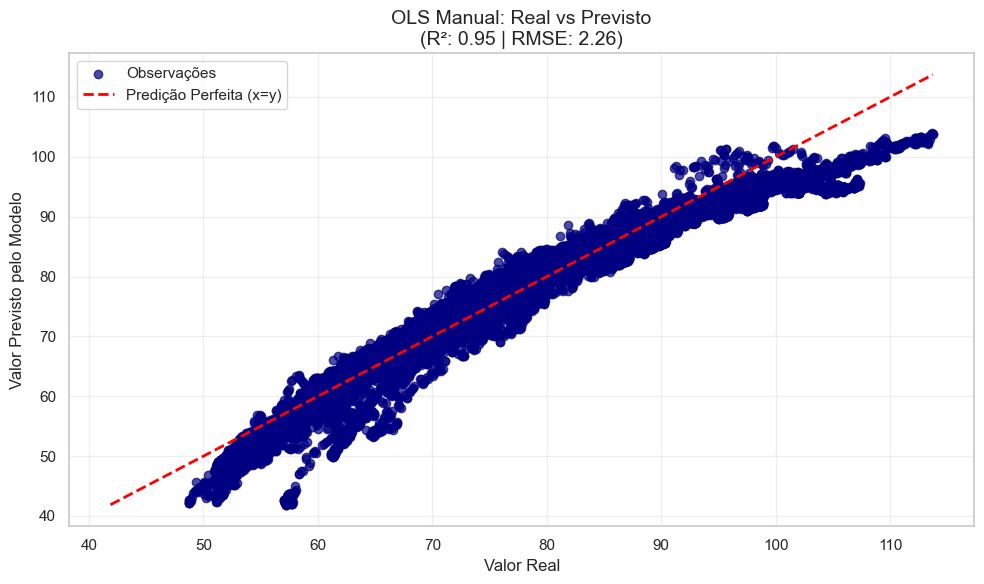

In [11]:
# ----------------------------------------------------------------------
# CÉLULA 6 - AVALIAÇÃO FINAL NO DATASET DE TESTE E GRÁFICO
# ----------------------------------------------------------------------

# 1. Previsão no Teste
y_pred_final = prever_ols(X_test, betas_finais)

# 2. Métricas Finais
rmse_test, r2_test = calcular_metricas(y_test, y_pred_final)

print(f"--- PERFORMANCE FINAL (CONJUNTO DE TESTE) ---")
print(f"R² Final: {r2_test:.4f}")
print(f"RMSE Final: {rmse_test:.4f}")

# 3. Gráfico de Dispersão (Real x Previsto)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.7, color='navy', label='Observações')

# Linha de Identidade (Ideal)
min_val = min(y_test.min(), y_pred_final.min())
max_val = max(y_test.max(), y_pred_final.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Predição Perfeita (x=y)')

plt.title(f'OLS Manual: Real vs Previsto\n(R²: {r2_test:.2f} | RMSE: {rmse_test:.2f})', fontsize=14)
plt.xlabel('Valor Real', fontsize=12)
plt.ylabel('Valor Previsto pelo Modelo', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()